In [1]:
import collections
from tqdm import tqdm
import statistics
import os
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tagname2tagid = {}
tagid2tagname = {}
idfocccounter = collections.defaultdict(lambda: 0)

In [3]:
def load_anime():
    charactercount = 0
    characterstat = collections.defaultdict(lambda: 0.0)
    characters = collections.defaultdict(lambda: copy.deepcopy(characterstat))
    animes = collections.defaultdict(lambda: copy.deepcopy(characters))
    
    for anime in tqdm(list(os.listdir("BIG_animedump"))):
        for character in list(os.listdir(f"BIG_animedump/{anime}")):
            with open(f"BIG_animedump/{anime}/{character}", "r") as f:
                data = f.read().split("\n")
                for l in data[1:-1]:
                    tagc, tagid, tagname = l.split()
                    tagc = int(tagc[:-1])
                    tagid = int(tagid[:-1])
                    animes[anime][character[:-4]][tagid] = tagc
                    tagname2tagid[tagname] = tagid
                    tagid2tagname[tagid] = tagname
                    idfocccounter[tagid] += 1
                    charactercount += 1
                    
    return (charactercount, animes)

In [4]:
charactercount, animedata = load_anime()

100%|██████████| 18265/18265 [00:05<00:00, 3223.13it/s]


In [5]:
def calculate_tfidf(character):
    terms = sum(character[k] for k in character.keys())
    tfidfd = collections.defaultdict(lambda: 0.0)

    for k in character.keys():
        tfidfd[k] = character[k]/terms * np.log10(charactercount/idfocccounter[k])

    ksum = sum(tfidfd[k] for k in tfidfd.keys())
    for k in tfidfd.keys():
        tfidfd[k] = tfidfd[k]/ksum
        
    return tfidfd

calculate_tfidf(animedata["to_aru_kagaku_no_railgun"]["saten_ruiko"])

defaultdict(<function __main__.calculate_tfidf.<locals>.<lambda>()>,
            {470575: 0.04527340628687736,
             13197: 0.044506677130702756,
             13200: 0.04808174171481203,
             212816: 0.03622923494195089,
             380350: 0.04444744061484456,
             464559: 0.04487404504469739,
             400123: 0.049168753118010035,
             16509: 0.03512027891105016,
             268819: 0.03921972814510136,
             1424211: 0.06789316523140734,
             10960: 0.0245714405011796,
             429: 0.020508261460976108,
             1815: 0.01733515523633239,
             10959: 0.01339639973392553,
             3389: 0.011514512300331466,
             8601: 0.008383376993373838,
             11906: 0.007263478170679987,
             461042: 0.007478845450164492,
             444: 0.006578478260717748,
             9294: 0.006171469588756754,
             469576: 0.005382129510402082,
             667868: 0.005721851152489973,
             384

In [6]:
def calculate_cosine(character1, character2):
    char1tfidf = calculate_tfidf(character1)
    char2tfidf = calculate_tfidf(character2)
    
    licznik = 0.0
    for k in set(list(char1tfidf.keys()) + list(char2tfidf.keys())):
        licznik += char1tfidf[k] * char2tfidf[k]
    
    m1 = sum(char1tfidf[k]**2.0 for k in char1tfidf.keys())
    m2 = sum(char2tfidf[k]**2.0 for k in char2tfidf.keys())

    if math.isnan(licznik/(math.sqrt(m1) * math.sqrt(m2))):
        return -1.0
    return licznik/(math.sqrt(m1) * math.sqrt(m2))

In [7]:
atmp = []
for character in animedata["kobayashi-san_chi_no_maidragon"].keys():
    atmp.append(( 
        calculate_cosine(
            animedata["kobayashi-san_chi_no_maidragon"][character], 
            animedata["kobayashi-san_chi_no_maidragon"]["tooru"]
        ), character)
    )
    
for e in sorted(atmp, reverse=True):
    print(e)

(0.9999999999999981, 'tooru')
(0.6500364403845912, 'kobayashi')
(0.6078209256463203, 'quetzalcoatl')
(0.5951911257809686, 'kanna_kamui')
(0.5646422961790136, 'iruru')
(0.522781497339611, 'elma')
(0.4606970398501725, 'saikawa_riko')
(0.4028081470716919, 'magatsuchi_shouta')
(0.2971333831579558, 'saikawa_sanae')
(0.27074603094660443, 'fafnir')
(0.11277539184669524, 'takiya_makoto')
(0.015003841119457587, 'katsuki_yuuri')


In [8]:
atmp = []
for anime in tqdm(animedata.keys()):
    for character in animedata[anime].keys():
        try:
            atmp.append(( 
                calculate_cosine(
                    animedata[anime][character], 
                    animedata["kobayashi-san_chi_no_maidragon"]["tooru"]
                ), character, anime)
            )
        except Exception as e:
            print(anime, character)
            

100%|██████████| 5646/5646 [01:16<00:00, 74.08it/s] 


In [9]:
for e in sorted(atmp, reverse=True)[:10]:
    print(e)

(0.9999999999999981, 'tooru', 'kobayashi-san_chi_no_maidragon')
(0.6792467286376486, 'au_ra', 'final_fantasy_xiv')
(0.6792467286376486, 'au_ra', 'final_fantasy')
(0.6705165756166139, 'beatrice', 'soccer_spirits')
(0.6500364403845912, 'kobayashi', 'kobayashi-san_chi_no_maidragon')
(0.6078209256463203, 'quetzalcoatl', 'kobayashi-san_chi_no_maidragon')
(0.598232660304175, 'karin', 'puzzle_&_dragons')
(0.5953173733566357, 'kuryuu_kohaku', 'concon-collector')
(0.5951911257809686, 'kanna_kamui', 'kobayashi-san_chi_no_maidragon')
(0.5854564838505576, 'myr', 'puzzle_&_dragons')


In [10]:
def calculate_series_similarity(series1, series2):
    atmp = []
    #print(len(animedata[series1].keys()), len(animedata[series2].keys()))
    t1 = list(animedata[series1].keys())
    t2 = list(animedata[series2].keys())
    
    f1 = []
    f2 = []
    sizeconst = 64
    if len(t1) < sizeconst:
        f1 = t1
    else:
        ind = np.random.choice(len(t1), sizeconst, replace=False)
        for i in ind:
            f1.append(t1[i])

    if len(t2) < sizeconst:
        f2 = t2
    else:
        ind = np.random.choice(len(t2), sizeconst, replace=False)
        for i in ind:
            f2.append(t2[i])

    for charactera in f1:
        for characterb in f2: 
            atmp.append(( 
                calculate_cosine(
                    animedata[series1][charactera], 
                    animedata[series2][characterb]
                ), charactera, characterb)
            )
    
    resmap = [q[0] for q in atmp]
    return (min(resmap), max(resmap), statistics.mean(resmap))
    
print(calculate_series_similarity("nekopara", "kobayashi-san_chi_no_maidragon"))
print(calculate_series_similarity("nekopara", "asobi_ni_iku_yo!"))

(0.0, 0.4710330441368347, 0.23593691467242672)
(0.17370068582234513, 0.630942176413259, 0.37067900425897216)


In [11]:
def load_animedict():
    id2booruname = collections.defaultdict(lambda: (None, None))
    with open("conversion_dictionary.csv", "r") as f:
        for a in f.read().split("\n")[1:]:
            try:
                malid, boorun, confidence = a.split(",")
                id2booruname[int(malid)] = (boorun[1:], float(confidence))
            except Exception as e:
                print(f"thrown {e}")
                print(f"for {a}")
                
    return id2booruname
            
id2boorunamed = load_animedict()

thrown not enough values to unpack (expected 3, got 1)
for 


In [12]:
print(id2boorunamed[38924])
print(id2boorunamed[6166])

def idbased_seriesdistance(id1, id2):
    anime1, confidence1 = id2boorunamed[id1]
    anime2, confidence2 = id2boorunamed[id2]
    if anime1 and anime2:
        return (calculate_series_similarity(anime1, anime2), (confidence1, confidence2))
    else:
        return ((100000000, 100000000, 100000000), (0.0, 0.0))
    
idbased_seriesdistance(38924, 6166)

('nekopara', 0.009940357852882704)
('asobi_ni_iku_yo!', 0.02054340622929092)


((0.17370068582234513, 0.630942176413259, 0.37067900425897216),
 (0.009940357852882704, 0.02054340622929092))

In [13]:
def load_marks():
    userrating = collections.defaultdict(lambda: [])
    with open("rating.csv", "r") as f:
        for t in f.read().split("\n")[1:]:
            try:
                userid, animeid, mark = t.split(",")
                userrating[int(userid)].append((int(animeid), int(mark)))
            except Exception as e:
                print(f"thrown {e}")
                print(f"for {t}")
    return userrating


In [14]:
user_ratings = load_marks()

thrown not enough values to unpack (expected 3, got 1)
for 


In [19]:
memcache = {}
def calculate_score(target_id, rratings, id2boorunamed):
    ratings = []
    for r in rratings:
        if r[1] == -1:
            pass
        else:
            ratings.append(r)
    
    if len(ratings) == 1:
        return "A", [5.0 for _ in range(200)]
    
    targetname, target_conf = id2boorunamed[target_id]
    
    if targetname == None:
        return "B", [5.0 for _ in range(200)]

    distmapv = []
    for serieid, serierating in ratings:
        if serieid != target_id:
            seriename, serieconf = id2boorunamed[serieid]
            if seriename:
                try:
                    if (targetname, seriename) in memcache:
                        seriesim = memcache[(targetname, seriename)]
                    else:
                        seriesim = calculate_series_similarity(targetname, seriename)
                        memcache[(targetname, seriename)] = seriesim
                    distmapv.append((seriesim[2], serierating))
                except Exception as e:
                    distmapv.append((0.0, serierating))
    #print(distmapv)
    q = sorted(distmapv, reverse=True)
    
    finscores = []
    licznik = 0.0
    mianownik = 0.0001
    
    if len(q) == 0:
        return "C", [5.0 for _ in range(200)]
    
    dudes = []
    #for sd, ss in q:
    #    dudes.append(ss)
    #    finscores.append(sum(dudes)/len(dudes))
    
    for sd, ss in q:
        licznik += sd*ss
        mianownik += sd
        finscores.append(licznik/mianownik)
    
    keep = finscores[-1]
    while len(finscores) < 200:
        finscores.append(keep)
    
    return True, finscores

def calculate_mse(target, target_rating, scoring):
    ts = 0
    for aid, sc in target_rating:
        if aid == target:
            ts = sc
    if ts == -1:
        raise NotImplemented
    return [(s-ts)**2 for s in scoring]

def runtest(target, id2boorunamed):
    oks = 0
    fails = 0
    ok_mse = []
    fail_mse = []
    with open(target, "r") as f:
        testdata = f.read().split("\n")[:-1]
        for t in tqdm(testdata):
            userid, animeid = t.split(" ")
            sure, scores = calculate_score(int(animeid), user_ratings[int(userid)], id2boorunamed)
            msescore = calculate_mse(int(animeid), user_ratings[int(userid)], scores)
            if sure == True:
                oks += 1
                ok_mse.append(msescore)
            else:
                fail_mse.append(msescore)
                fails += 1
    return ok_mse, fail_mse
    


In [24]:
for fh in ["newbies.txt", "connoisseur.txt", "random.txt", "popular.txt"]:
    ok_mse, fail_mse = runtest(fh, id2boorunamed)
    flattened_ok = flatten_mse(ok_mse)
    flattened_guess = flatten_mse(fail_mse)
    flattened_all = flatten_mse(ok_mse + fail_mse)
    with open(f"dbv_errors/errors_{fh}", "w") as f:
        f.write(f"{len(ok_mse)}, {len(fail_mse)}\n")
        for dim in range(200):
            f.write(f"{flattened_ok[dim]}, {flattened_all[dim]}\n")
        

100%|██████████| 500/500 [24:45<00:00,  2.97s/it]  


2.4209434704320416
296


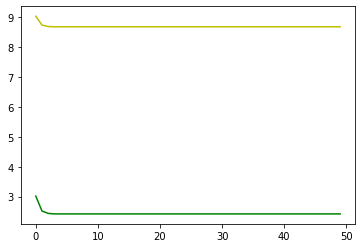

In [16]:
def flatten_mse(mselist):
    mselen = len(mselist)
    finmse = [0.0 for _ in range(200)]
    
    for dim in range(200):
        s = 0
        for dude in mselist:
            s += dude[dim]
        finmse[dim] = s/mselen
    return finmse
    
plt.plot([i for i in range(50)], flattened_ok[:50], c ='g')
plt.plot([i for i in range(50)], flattened_all[:50], c ='y')
print(min(flattened_ok))
print(len(ok_mse))


In [17]:
ok_mse, fail_mse = runtest("random.txt", id2boorunamed)

100%|██████████| 500/500 [49:27<00:00,  5.94s/it]  


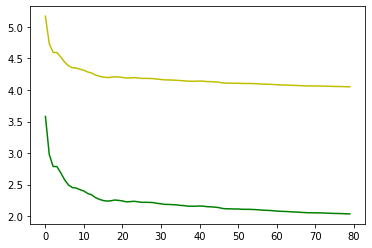

In [18]:
flattened_ok = flatten_mse(ok_mse)
flattened_guess = flatten_mse(fail_mse)
flattened_all = flatten_mse(ok_mse + fail_mse)

plt.plot([i for i in range(80)], flattened_ok[:80], c ='g')
plt.plot([i for i in range(80)], flattened_all[:80], c ='y')

In [ ]:
print(min(flattened_ok))

In [ ]:
ok_mse, fail_mse = runtest("connoisseur.txt", id2boorunamed)

In [ ]:
flattened_ok = flatten_mse(ok_mse)
flattened_guess = flatten_mse(fail_mse)
flattened_all = flatten_mse(ok_mse + fail_mse)
plt.plot([i for i in range(200)], flattened_ok[:200], c ='g')
plt.plot([i for i in range(200)], flattened_all[:200], c ='y')

In [ ]:
print(min(flattened_ok))
print(len(ok_mse))

100%|██████████| 500/500 [00:00<00:00, 281761.66it/s]


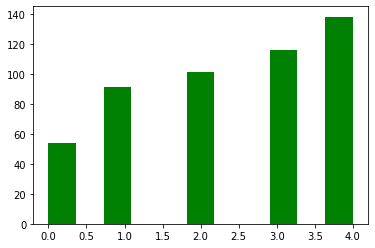

In [41]:
histv = []
with open("newbies.txt", "r") as f:
    testdata = f.read().split("\n")[:-1]
    for t in tqdm(testdata):
        userid, animeid = t.split(" ")
        ur = [ur[1] for ur in user_ratings[int(userid)]]
        urs = []
        for e in ur:
            if e != -1:
                urs.append(e)
        histv.append(len(urs)-1)

plt.hist(histv, 11, facecolor='g')
plt.show()